# Hotel Sentiment Analysis

# Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Functions

In [7]:
def check_null_dupes(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of dupes: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.legend(unique)
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()
  
def remove_stop_words(content):
  word_tokens = " ".join(word_tokenize(content))
  
  filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', "", word_tokens).split(" ")
  filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()

def plot_learning_curves(history):
  acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]
  loss, val_loss = history.history["loss"], history.history["val_loss"]
  epochs= range(1,len(acc)+1)
  plt.figure(figsize=(15, 8))
  
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, "bo-", label="Training Accuracy")
  plt.plot(epochs, val_acc, "gs-", label="Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training and Validation Accuracy")
  plt.legend()
  
  plt.subplot(1,2,2)
  plt.plot(epochs, loss, "bo-", label="Training Loss")
  plt.plot(epochs, val_loss, "gs-", label="Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training and Validation Loss")
  plt.legend()
  
  plt.tight_layout()
  plt.show()
  

# EDA Analysis

In [8]:
df = pd.read_csv("/Users/maukanmir/Downloads/hotel.csv")
df

,Unnamed: 0,content,translated_content,priority_score,problem_domain
0,1,"Sorry, including the expensive price + apk usi...","Sorry, including the expensive price + apk usi...",2,0
1,2,Setelah install terus pas buka aplikasi ngebla...,"After installed, the app stuck with white display",3,1
2,3,"gak bisa submit pada saat verifikasi data, pad...","Cannot submit the data verification, even my i...",3,1
3,4,Aplilasi restart mulu,The app keep restarting,3,1
4,5,"udah mahal , makanan ga enak, banyak lalat","Overpriced, bad food, too many flies",2,0
...,...,...,...,...,...
695,696,Mohon yang bersihin kamar mandi laki2 khusus l...,Please clean the men's bathrooms specifically ...,2,0
696,697,Kurang kedap suara. Kebangun gara2 pod sebelah...,Loading...,2,0
697,698,Would be nice if people could leave luggage af...,Would be nice if people could leave luggage af...,2,0
698,699,Matrasnya ternyata keras bgt\nDiluar itu so fa...,The mattress turned out to be really hard\nApa...,2,0


# Check for Nulls and Dupes

In [9]:
check_null_dupes(df)

The amount of Nulls: Unnamed: 0            0
content               0
translated_content    0
priority_score        0
problem_domain        0
dtype: int64
The amount of dupes: 0


# Check for Class Imabalance

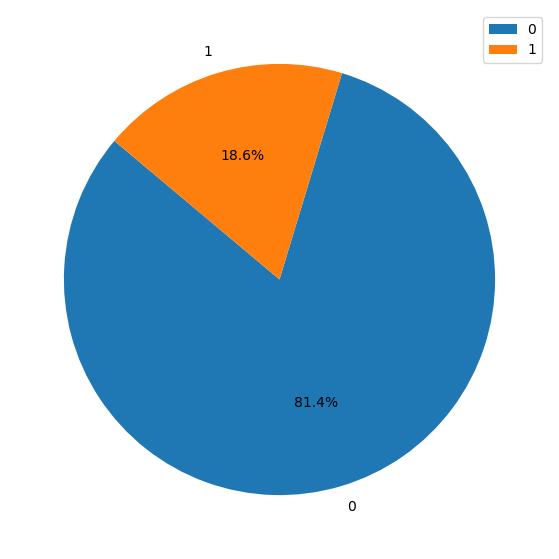

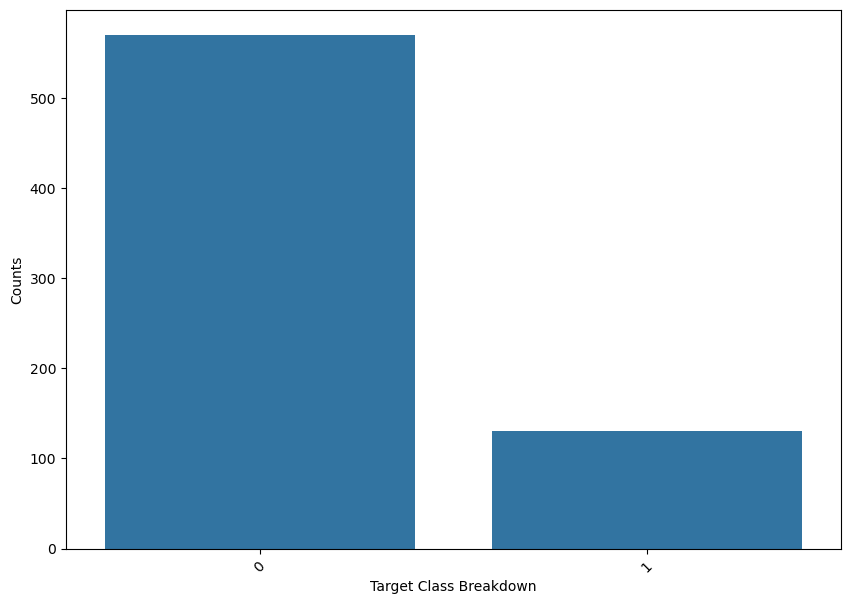

In [10]:
check_class_imbalance(df["problem_domain"])

# Deeply Skewed Class Imbalance

# Drop uneeded columns

In [11]:
df.drop(["Unnamed: 0", "content"], axis=1, inplace=True)

# Transalted Content Review Visuals

In [12]:
df["len_review"] = df["translated_content"].apply(lambda x: len(x))
df["len_wordcount"] = df["translated_content"].apply(lambda x: len(x.split()))

In [13]:
df.describe()

,priority_score,problem_domain,len_review,len_wordcount
count,700.000000,700.000000,700.000000,700.000000
mean,2.184286,0.185714,85.847143,15.421429
std,0.757629,0.389154,144.241753,26.676805
min,1.000000,0.000000,2.000000,1.000000
25%,2.000000,0.000000,10.000000,1.000000
50%,2.000000,0.000000,27.000000,5.000000
75%,3.000000,0.000000,100.500000,19.000000
max,3.000000,1.000000,1381.000000,260.000000


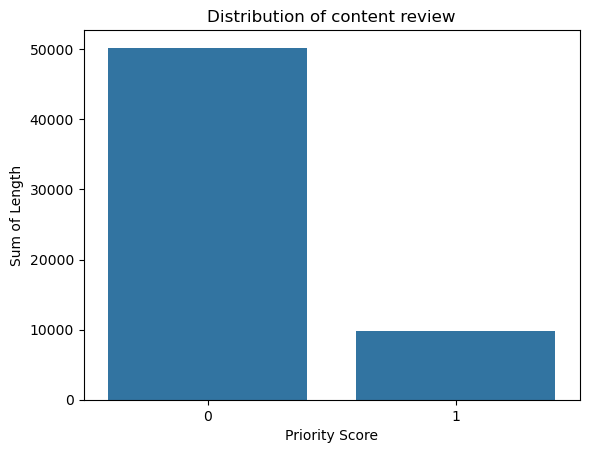

In [14]:
grouped_df = df.groupby("problem_domain")["len_review"].sum().reset_index()

sns.barplot(data=grouped_df, x='problem_domain', y="len_review")
plt.title("Distribution of content review")
plt.xlabel("Priority Score")
plt.ylabel("Sum of Length")
plt.yscale("linear")
plt.show()

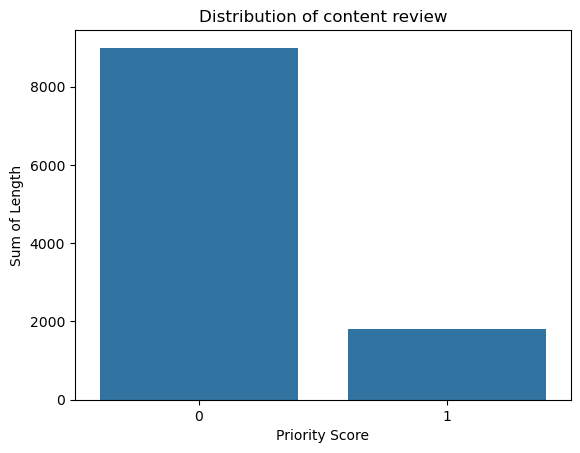

In [15]:
grouped_df = df.groupby("problem_domain")["len_wordcount"].sum().reset_index()

sns.barplot(data=grouped_df, x='problem_domain', y="len_wordcount")
plt.title("Distribution of content review")
plt.xlabel("Priority Score")
plt.ylabel("Sum of Length")
plt.yscale("linear")
plt.show()

# Data Preprocessing

In [16]:
df["translated_content"] = df["translated_content"].apply(remove_stop_words)

# Separate Features

In [29]:
X, y = df.drop("problem_domain", axis=1), df["problem_domain"]

# Encode Target Class

In [30]:
NUM_CLASSES = 1

# Bert Model

In [31]:
model_name = "distilbert-base-uncased"
tokenzier = AutoTokenizer.from_pretrained(model_name)

In [41]:
model = Sequential()
vocab_size = len(tokenzier.get_vocab())+1
model.add(Embedding(input_dim=vocab_size, output_dim=32))
model.add(Bidirectional(LSTM(32, activation="tanh")))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(528, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [42]:
seq = [sequence for sequence in X["translated_content"]]
model_inputs = tokenzier(seq, padding=True, return_tensors="tf")

In [43]:
dataset = tf.data.Dataset.from_tensor_slices((model_inputs["input_ids"], y))

In [44]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [45]:
len_dataset = len(dataset)

train = dataset.take(int(len_dataset * 0.7))
test = dataset.skip(int(len_dataset * 0.7)).take(int(len_dataset * 0.2))
val = dataset.skip(int(len_dataset * 0.9))

In [46]:
early_stopping = EarlyStopping(
  monitor="val_loss",
  verbose=0,
  patience=10,
  restore_best_weights=True,
  min_delta=0.01
)

In [47]:
history = model.fit(
  train,
  epochs=10,
  batch_size=16,
  verbose=0,
  validation_data=val,
  callbacks=[early_stopping]
)

# Plot Learning Curves

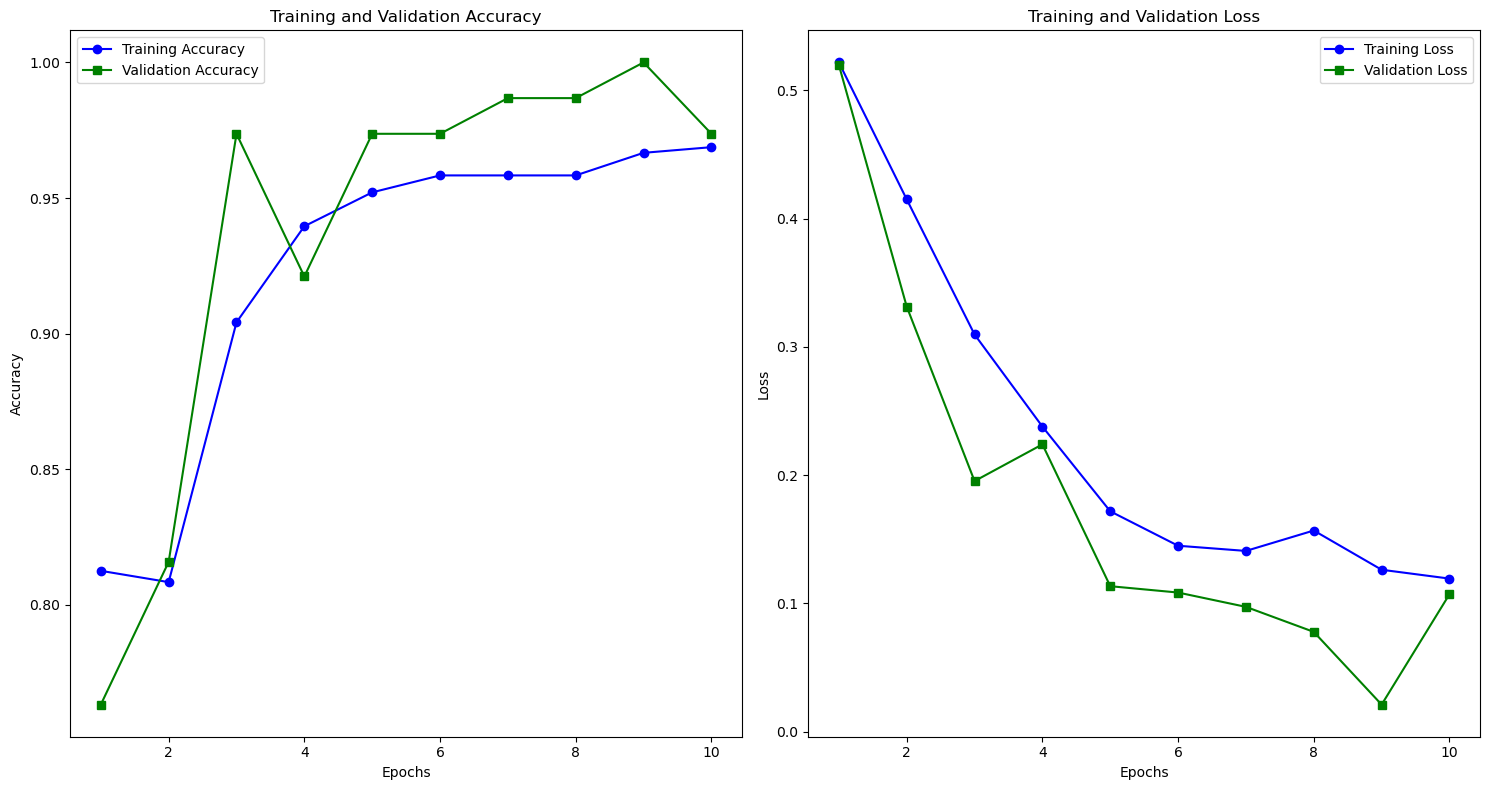

In [48]:
plot_learning_curves(history)

# Model Test Accuracy

In [49]:
test_loss, test_acc = model.evaluate(test, steps=10)
print("Test Accuracy", test_acc)

10/10 [==============================] - 0s 4ms/step - loss: 0.1153 - accuracy: 0.9688
Test Accuracy 0.96875
